In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import os
import torch
import argparse
import yaml
from numba import cuda

from helpers.density_estimator import DensityEstimator
from helpers.ANODE_training_utils import train_ANODE, plot_ANODE_losses
from helpers.data_transforms import clean_data
from helpers.physics_functions import get_bins, get_bins_for_scan
from helpers.stats_functions import curve_fit_m_inv, parametric_fit, calculate_chi2, build_histogram, binned_likelihood

from helpers.plotting import *
#from helpers.flow_sampling import get_mass_samples, get_flow_samples

In [12]:
"""
"
"
MISC VARIABLES TO LOAD IN FLOW
window_index = 100, 40 has 2 peaks
window_index = 29, 108 has 1 peak
"
"
"""
window_index = 100 


use_inner_bands = False
train_samesign = False
no_train = True
premade_bins = True
feature_list = "dimu_pt,mu0_ip3d,mu1_ip3d,dimu_mass"
feature_id = "mix_2"
configs = "CATHODE_8"
bootstrap = f"window{window_index}"
seed = 1

if use_inner_bands:bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
else: bands = ["SBL", "SR", "SBH"]

if train_samesign: samesign_id = "SS"
else: samesign_id = "OS"

feature_set = [f for f in feature_list.split(",")]
print(f"Using feature set {feature_set}")
num_features = len(feature_set) - 1 # context doesn't count

import yaml
with open(f"workflow_scan.yaml", "r") as file:
    workflow = yaml.safe_load(file)

print(f"Feature id: {feature_id}")
print(f"Analysis:", workflow["analysis_keywords"]["name"])

# directories
working_dir = workflow["file_paths"]["working_dir"]
path_to_config_file = f"{working_dir}/configs/{configs}.yml"
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/{bootstrap}_{samesign_id}/{feature_id}/{configs}/seed{seed}"
os.makedirs(flow_training_dir, exist_ok=True)

Using feature set ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']
Feature id: mix_2
Analysis: lowmass_scan_12_20_HLT_TrkMu15_DoubleTrkMu5NoFiltersNoVtx


In [13]:
"""
# computing / cuda
device = cuda.get_current_device()
device.reset()
torch.set_num_threads(2)
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)
seed = int(seed)
torch.manual_seed(seed)
np.random.seed(seed)
"""

'\n# computing / cuda\ndevice = cuda.get_current_device()\ndevice.reset()\ntorch.set_num_threads(2)\ndevice = torch.device( "cuda" if torch.cuda.is_available() else "cpu")\nprint( "Using device: " + str( device ), flush=True)\nseed = int(seed)\ntorch.manual_seed(seed)\nnp.random.seed(seed)\n'

In [14]:
"""
"
"
LOAD IN DEDICATED TRAIN DATA FOR FLOW
"
"
"""

data_dict = {}
print(f"{processed_data_dir}/{bootstrap}_{samesign_id}_test_band_data")

# dataset for the bump hunt only
with open(f"{processed_data_dir}/{bootstrap}_{samesign_id}_test_band_data", "rb") as ifile:
    proc_dict_s_inj_test = pickle.load(ifile)

for b in bands:
    num_events_band = proc_dict_s_inj_test[b]["dimu_mass"].shape[0]
    data_dict[b] = np.empty((num_events_band, num_features+1))
    for i, feat in enumerate(feature_set):
        data_dict[b][:,i] = proc_dict_s_inj_test[b][feat].reshape(-1,1).reshape(-1,)
    print("{b} data has shape {length}.".format(b = b, length = data_dict[b].shape))

data_dict["SBL"] = clean_data(data_dict["SBL"])
data_dict["SBH"] = clean_data(data_dict["SBH"])

data_dict["SB"] =  np.vstack((data_dict["SBL"], data_dict["SBH"]))
if use_inner_bands:
    data_dict["IB"] =  np.vstack((data_dict["IBL"], data_dict["IBH"]))


/global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/lowmass_scan_12_20_HLT_TrkMu15_DoubleTrkMu5NoFiltersNoVtx/processed_data/window100_OS_test_band_data
SBL data has shape (49470, 4).
SR data has shape (2256, 4).
SBH data has shape (6166, 4).


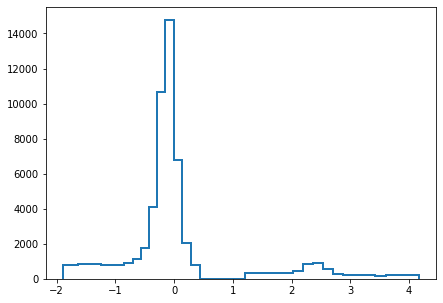

In [15]:
"""
"
"
PLOT THE MASS WINDOW
"
"
"""
masses_to_fit = np.hstack((data_dict["SBL"][:,-1], data_dict["SBH"][:,-1]))
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins_for_scan(processed_data_dir, window_index, scale_bins = True)
SR_left, SR_right = plot_bins_SR[0], plot_bins_SR[-1]
SB_left, SB_right = plot_bins_left[0], plot_bins_right[-1]


plt.figure(figsize = (7,5))
plt.hist(masses_to_fit, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = "SB data") 

plt.show()


# New code: fitting polynomial + n DCBs

In [16]:
from scipy.special import erf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize

In [17]:
# define asymmetric double crystal ball with 7 fit params

n_dof_DCB = 7

def DCB(x, mu, sigma, N, alpha_L, n_L, alpha_R, n_R):

    n_L = np.abs(n_L)
    n_R = np.abs(n_R)

    A_L = ((n_L/np.abs(alpha_L))**n_L)*np.exp(-np.abs(alpha_L)**2 / 2.0)
    A_R = ((n_R/np.abs(alpha_R))**n_R)*np.exp(-np.abs(alpha_R)**2 / 2.0)

    B_L = (n_L / np.abs(alpha_L)) - np.abs(alpha_L)
    B_R = (n_R / np.abs(alpha_R)) - np.abs(alpha_R)

    # normalization factor
    norm = sigma*((A_L*(alpha_L + B_L)**(1.0 - n_L) / (-1.0 + n_L)) +  (A_R*(alpha_R + B_R)**(1.0 - n_R) / (-1.0 + n_R)) +  np.sqrt(np.pi/2)*(erf(alpha_L/np.sqrt(2))+erf(alpha_R/np.sqrt(2))))

    y = np.zeros_like(x)
    z = (x - mu) / sigma
    # left tail
    y += np.where(z < -alpha_L, A_L*(B_L - z)**(-n_L), 0)
    # right tail
    y += np.where(z > alpha_R, A_R*(B_R + z)**(-n_R), 0)  
    # gaussian core
    y += np.where((z >= -alpha_L) & (z <= alpha_R), np.exp(-0.5*z**2), 0)  
    return N*y/norm

In [18]:
# define function to fit background + DCB to mass
def curve_fit_bkg_peaks(masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB, N_peaks,
                        weights = None, p0_bkg=None, distance_peaks=3):
    
    if weights is None:
        weights = np.ones_like(masses)

    """
    HISTOGRAM MASSES
    """
   
    # get left SB data
    loc_bkg_left = masses[masses < SR_left]
    weights_left = weights[masses < SR_left]
    plot_centers_left = 0.5*(plot_bins_left[1:]+plot_bins_left[:-1])
    y_vals_left, y_counts_left, bins_left, bin_weights_left, bin_err_left = build_histogram(loc_bkg_left, weights_left, plot_bins_left)

    # get right SB data
    loc_bkg_right = masses[masses > SR_right]
    weights_right = weights[masses > SR_right]
    plot_centers_right = 0.5*(plot_bins_right[1:]+plot_bins_right[:-1])
    y_vals_right, y_counts_right, bins_right, bin_weights_right, bin_err_right = build_histogram(loc_bkg_right, weights_right, plot_bins_right)

    # concatenate the SB data
    y_vals = np.concatenate((y_vals_left, y_vals_right))
    errs = np.concatenate((bin_err_left, bin_err_right))
    y_err = np.sqrt(errs**2 + 1)


    if N_peaks == 0: #  NO PEAKS -- JUST FIT POLYNOMIAL
        average_bin_count = np.mean(y_vals)

        # initialize p0
        p0 = [average_bin_count] + [0 for i in range(fit_degree)]
        n_dof_fit = fit_degree + 1
        fit_function = parametric_fit
        
        # set bounds for the curve_fit optimization (not really necessary for polynomial)
        lower_bounds = [-np.inf for x in range(n_dof_fit)]
        upper_bounds = [np.inf for x in range(n_dof_fit)]
        
        # fit the SB data with regular curvefit
        popt, pcov = curve_fit(fit_function, plot_centers_SB, y_vals, p0, sigma = y_err, maxfev=20000, bounds = (lower_bounds, upper_bounds))


    elif N_peaks > 0: # N PEAKS -- FIT POLYNOMIAL + DCB

        if p0_bkg is None:
            print("Must supply background guess.")
            return

        # define the fit function in-place with N_peaks
        def fit_function(x, *theta):
            y = np.zeros_like(x)
            for n_peak in range(N_peaks):
                # sum DCBs
                y += DCB(x, theta[n_peak*n_dof_DCB], theta[n_peak*n_dof_DCB+1], theta[n_peak*n_dof_DCB+2], 
                         theta[n_peak*n_dof_DCB+3], theta[n_peak*n_dof_DCB+4], theta[n_peak*n_dof_DCB+5], theta[n_peak*n_dof_DCB+6])
            # polynomial 
            y += parametric_fit(x, *theta[N_peaks*n_dof_DCB:])
            return y

        # define the likelihood in-place
        def likelihood(theta):
             # Log poisson likelihood for the SB bins
            log_likelihood = 0
            fit_vals_left = fit_function(plot_centers_left, *theta)
            fit_vals_right = fit_function(plot_centers_right, *theta)
            
            log_likelihood += binned_likelihood(y_vals_left, y_counts_left, bin_weights_left, fit_vals_left)
            log_likelihood += binned_likelihood(y_vals_right, y_counts_right, bin_weights_right, fit_vals_right)
              
            return -2 * log_likelihood


        # initialize p0
        # currently, I find peaks by looking for local maxima, i.e. I look for bins that are greater than
                # their distance_peaks neighbors. The local maxima with the N_peaks highest counts (y values)
                # are used for the p0 initialization
        found_peak_indices, found_peak_info = find_peaks(y_vals, distance=distance_peaks, height=0)
        high_to_low_peaks = np.argsort(found_peak_info["peak_heights"])[::-1]
        high_to_low_peak_x = plot_centers_SB[found_peak_indices[high_to_low_peaks]]
        high_to_low_peak_y = found_peak_info["peak_heights"][high_to_low_peaks]

        # p0_DCB contains mu, sigma, N, alpha_L, n_L, alpha_R, n_R
        p0_DCB = []
        for n_peak in range(N_peaks):
            p0_DCB += [high_to_low_peak_x[n_peak], 0.5*distance_peaks*(plot_centers_SB[1] - plot_centers_SB[0]), high_to_low_peak_y[n_peak], 2, 2, 2, 2]
        p0 = p0_DCB + p0_bkg
        n_dof_fit = fit_degree + 1 + n_dof_DCB*N_peaks

        # set bounds for the optimizations (the bound n > 1 is necessary. The others are just to help optimization)
        lower_bounds = [np.min(plot_bins_left), 0, 0, 0, 1, 0, 1]*N_peaks + [-np.inf for x in range(fit_degree+1)]
        upper_bounds = [np.max(plot_bins_right), np.max(plot_bins_right)-np.min(plot_bins_right), np.inf, np.inf, np.inf, np.inf, np.inf]*N_peaks + [np.inf for x in range(fit_degree+1)]
        bounds =  [(lower_bounds[i], upper_bounds[i]) for i in range(len(lower_bounds))]
       
        # fit the SB data with regular curvefit to get an initial guess for popt
        p0, _ = curve_fit(fit_function, plot_centers_SB, y_vals, p0, sigma = y_err, maxfev=20000, bounds = (lower_bounds, upper_bounds))

        # then the SB data with scipy minimize
        fit = minimize(likelihood, x0 = p0, method = 'Nelder-Mead', options = {'maxiter': 16000, "disp": True}, bounds = bounds)
        popt = fit.x
        pcov = None
    
    # get chi2 in the SB
    chi2 = calculate_chi2(fit_function(plot_centers_SB, *popt), y_vals, y_err)

    return popt, pcov, chi2, y_vals, len(y_vals) - n_dof_fit, fit_function



In [19]:
# define F statistic function

from scipy.stats import f
def calculate_F_statistic_p_value(SSE_full, SSE_reduced, n_dof_full, n_dof_reduced):
    numerator = (SSE_reduced - SSE_full) / (n_dof_reduced - n_dof_full)
    denominator = SSE_full / n_dof_full
    Fstar = numerator / denominator
    print(f"F*: {Fstar}")
    p_value = 1 - f.cdf(Fstar, n_dof_reduced - n_dof_full, n_dof_full)
    print(f"p value: {p_value} for F distribution with ({ n_dof_reduced - n_dof_full}, {n_dof_full}) DOF")
    return p_value

In [20]:
# do the fitting

bkg_fit_degree = 5

# fit 0 peaks (only 1 optimization)
popt_bkg, _, chi2_bkg, _,  n_dof_bkg, fit_function_bkg = curve_fit_bkg_peaks(masses_to_fit, bkg_fit_degree, SR_left, SR_right, plot_bins_left, 
                                                      plot_bins_right, plot_centers_SB, 0)


# fit 1 peak (2 optimizations)
popt_reduced, _, chi2_reduced, _, n_dof_reduced, fit_function_reduced = curve_fit_bkg_peaks(masses_to_fit, bkg_fit_degree, SR_left, SR_right, plot_bins_left, 
                                                      plot_bins_right, plot_centers_SB,1, p0_bkg=list(popt_bkg))
p_value_10 = calculate_F_statistic_p_value(chi2_reduced, chi2_bkg, n_dof_reduced, n_dof_bkg)

    
# fit 2 peak (2 optimizations)
popt_full, _, chi2_full, _, n_dof_full, fit_function_full = curve_fit_bkg_peaks(masses_to_fit, bkg_fit_degree, SR_left, SR_right, plot_bins_left, 
                                                plot_bins_right, plot_centers_SB, 2, p0_bkg=list(popt_bkg))
p_value_21 = calculate_F_statistic_p_value(chi2_full, chi2_reduced, n_dof_full, n_dof_reduced)


/tmp/ipykernel_323934/2813776268.py:22: RuntimeWarning: invalid value encountered in power
  y += np.where(z < -alpha_L, A_L*(B_L - z)**(-n_L), 0)
/tmp/ipykernel_323934/2813776268.py:24: RuntimeWarning: invalid value encountered in power
  y += np.where(z > alpha_R, A_R*(B_R + z)**(-n_R), 0)


Optimization terminated successfully.
         Current function value: 1096.297509
         Iterations: 8592
         Function evaluations: 11562
F*: 108.63520739218848
p value: 4.773959005888173e-15 for F distribution with (7, 21) DOF


/tmp/ipykernel_323934/2813776268.py:10: RuntimeWarning: overflow encountered in double_scalars
  A_L = ((n_L/np.abs(alpha_L))**n_L)*np.exp(-np.abs(alpha_L)**2 / 2.0)
/tmp/ipykernel_323934/2813776268.py:11: RuntimeWarning: overflow encountered in double_scalars
  A_R = ((n_R/np.abs(alpha_R))**n_R)*np.exp(-np.abs(alpha_R)**2 / 2.0)
/tmp/ipykernel_323934/2813776268.py:17: RuntimeWarning: invalid value encountered in double_scalars
  norm = sigma*((A_L*(alpha_L + B_L)**(1.0 - n_L) / (-1.0 + n_L)) +  (A_R*(alpha_R + B_R)**(1.0 - n_R) / (-1.0 + n_R)) +  np.sqrt(np.pi/2)*(erf(alpha_L/np.sqrt(2))+erf(alpha_R/np.sqrt(2))))
/tmp/ipykernel_323934/2813776268.py:22: RuntimeWarning: invalid value encountered in multiply
  y += np.where(z < -alpha_L, A_L*(B_L - z)**(-n_L), 0)
/tmp/ipykernel_323934/2813776268.py:24: RuntimeWarning: invalid value encountered in multiply
  y += np.where(z > alpha_R, A_R*(B_R + z)**(-n_R), 0)
/tmp/ipykernel_323934/2813776268.py:27: RuntimeWarning: invalid value encounter

Optimization terminated successfully.
         Current function value: 301.617626
         Iterations: 5685
         Function evaluations: 7511
F*: 96.60624883939293
p value: 9.136313927626816e-11 for F distribution with (7, 14) DOF


/tmp/ipykernel_323934/2813776268.py:22: RuntimeWarning: invalid value encountered in power
  y += np.where(z < -alpha_L, A_L*(B_L - z)**(-n_L), 0)
/tmp/ipykernel_323934/2813776268.py:24: RuntimeWarning: invalid value encountered in power
  y += np.where(z > alpha_R, A_R*(B_R + z)**(-n_R), 0)


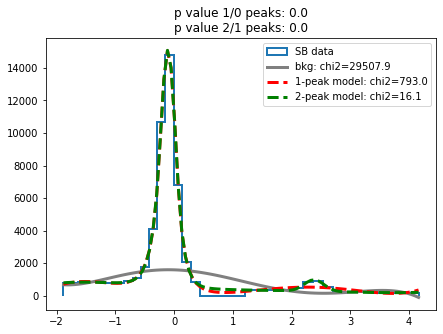

In [21]:
# plot the fits


x = np.linspace(SB_left, SB_right, 100) 


plt.figure(figsize = (7,5))
plt.hist(masses_to_fit, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = "SB data") 
plt.plot(x, fit_function_bkg(x, *popt_bkg), lw = 3, label = f"bkg: chi2={np.round(chi2_bkg, 1)}", color = "grey")
plt.plot(x, fit_function_reduced(x, *popt_reduced), lw = 3, linestyle = "dashed", label = f"1-peak model: chi2={np.round(chi2_reduced, 1)}", color = "r")
plt.plot(x, fit_function_full(x, *popt_full), lw = 3, linestyle = "dashed", label = f"2-peak model: chi2={np.round(chi2_full, 1)}", color = "g")
#plt.title(f"p value 1/0 peaks: {np.round(p_value_10, 3)}")
plt.title(f"p value 1/0 peaks: {np.round(p_value_10, 3)}\np value 2/1 peaks: {np.round(p_value_21, 3)}")

#plt.ylim(0, 8000)
plt.legend()
plt.show()


In [ ]:
"""
# to draw peakless samples from the SR, we need to first do a bkg fit in the SB

#masses_SR = data_dict["SR"][:,-1]


if use_full_model: 
    color_sample = "g"
    n_SR_samples = int(np.sum(full_fit_N_peaks(x, *popt_full)))
else: 
    color_sample = "r"
    n_SR_samples = int(np.sum(parametric_fit(x, *popt_reduced)))

# estimate number of samples

# make samples
mass_samples = get_mass_samples(SR_left, SR_right, fit_degree_sample, n_SR_samples, popt_sample)

plt.hist(mass_samples, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = "samples", color = color_sample)    
plt.ylim(0, 1000)
plt.xlabel("$m$ (rescaled)")
plt.ylabel("Counts")
"""

